In [117]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import proplot
import numpy as np

In [67]:
def open_monthly_data_var(var):
    try:
        data_var = xr.open_dataset(fr'../data/adjusted/{var}_1961_2023_monthly.nc')[var] # open the saved data
    except:
        data_var = xr.open_dataset(fr'../data/adjusted/{var}_1971_2023_monthly.nc')[var] # open the saved data

    return data_var

In [85]:
def resample_monthly_to_seasonal(data_var, resample_by='mean'):
    if resample_by=='mean':
        data_resampled = data_var.resample(time='QS-DEC').mean().mean(dim=['E', 'N']) # resample seasonally and then get the mean across E-N
    elif resample_by=='sum':
        data_resampled = data_var.resample(time='QS-DEC').sum().mean(dim=['E', 'N']) # resample seasonally and then get the mean across E-N
    return data_resampled

In [53]:
def get_seasonal_time_series(data_resampled, season=12):
    """
    data_resampled: data that is seasonally resampled
    season: either 12,3,6,9 corresponding to DJF,MAM,JJA,SON
    """
    data_resampled_season = data_resampled.time.dt.month.isin(season)
    return data_resampled[data_resampled_season]

In [ ]:
available_vars = ['TabsM', 'RhiresM', 'TmaxM', 'TminM']
available_vars_map = {'TabsM': 'Temperature', 'RhiresM': 'Precipitation', 
                      'TmaxM': 'Max. Temperature', 'TminM': 'Min. Temperature'}

season_val_map = {12:'DJF',
                  3: 'MAM',
                  6: 'JJA',
                  9: 'SON'}

var_color_map = {'TabsM': '#9370DB',
               'RhiresM': '#98FB98',
               'TmaxM': '#FF7F50',
               'TminM': '#87CEEB'}

/tmp/ipykernel_22677/699133457.py:69: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.set_xlabel('Years', fontsize=12, fontweight='bold')
/tmp/ipykernel_22677/699133457.py:73: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.set_xlim(1960, 2023)
/tmp/ipykernel_22677/699133457.py:74: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.tick_params(axis='x', labelrotation=90)
/tmp/ipykernel_22677/699133457.py:80: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid in

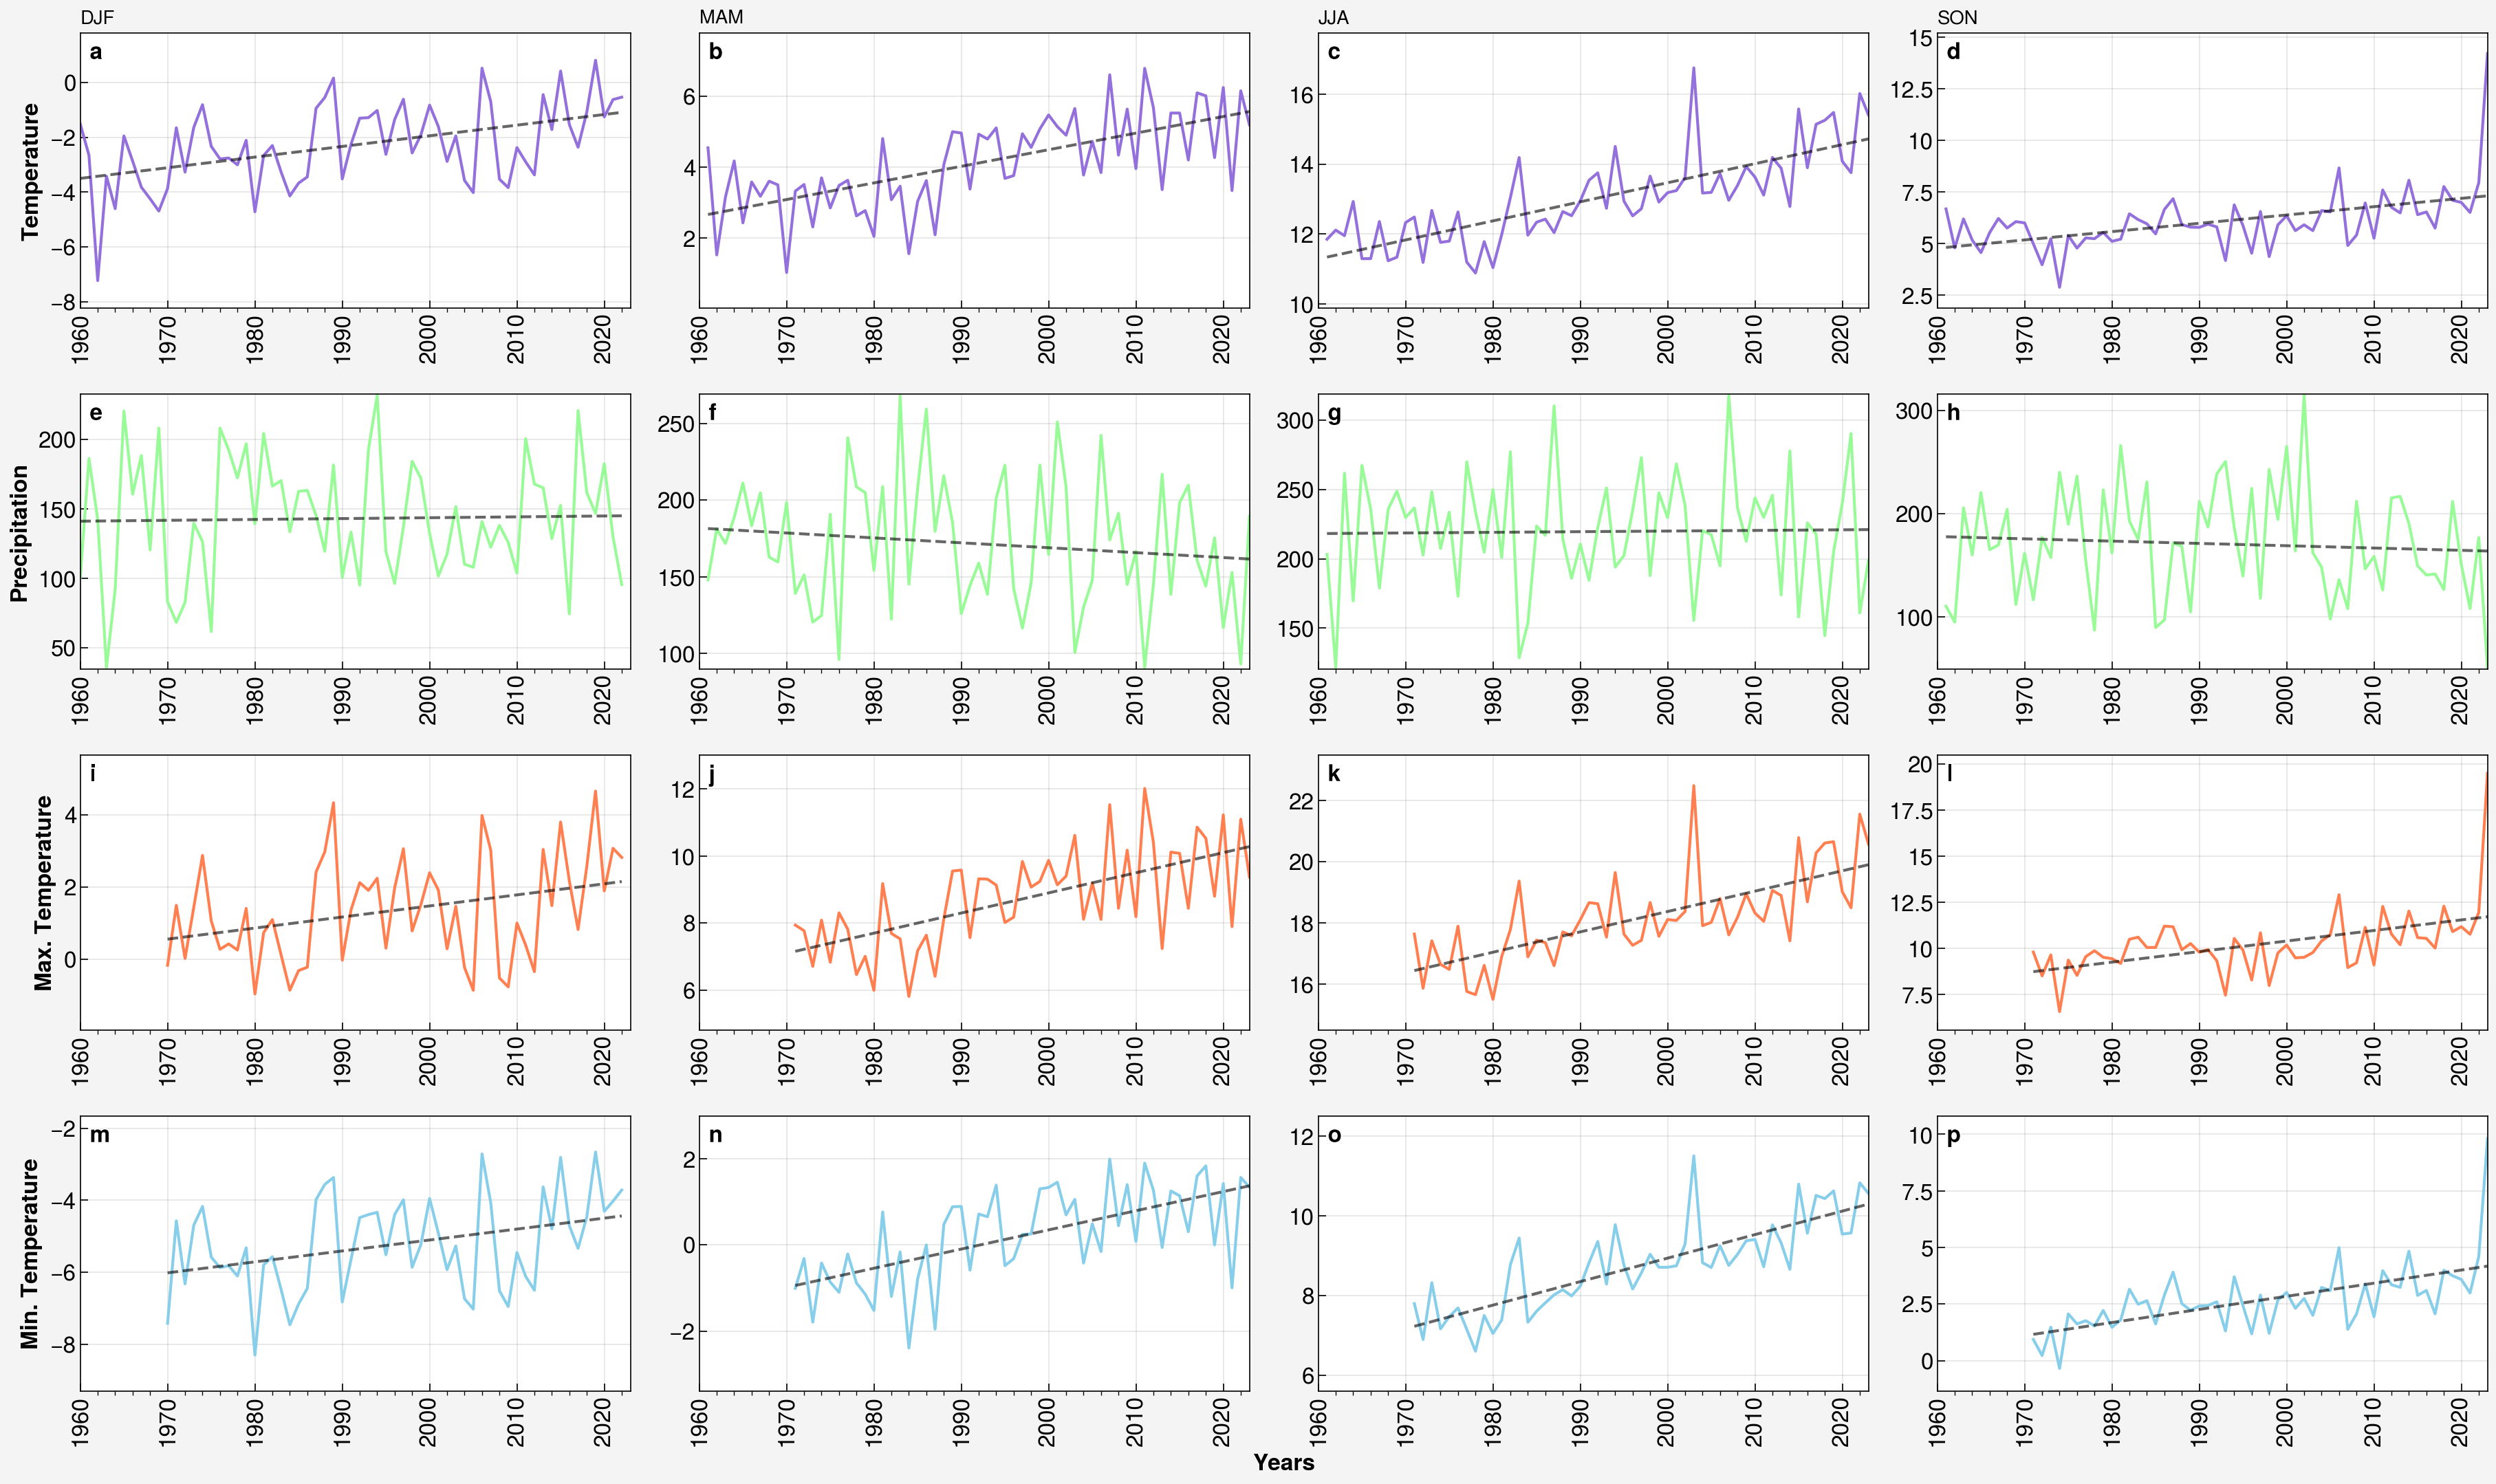

In [185]:
fig_array = [[1,2,3,4],
             [5,6,7,8],
             [9,10,11,12],
             [13,14,15,16]]

fig, axs = proplot.subplots(fig_array, 
                            axwidth=4,
                            axheight=2,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=5,
                            wspace=4,
                            sharey=0,
                            sharex=1)

turn = 0
for var_sel in available_vars:
    ds_var = open_monthly_data_var(var_sel)

    if var_sel=='RhiresM':
        resample_method = 'sum' # for the precipitation data, resample to seasons by summing them
    else:
        resample_method = 'mean' # for the temperature data, resample to seasons by averaging them
    
    ds_var_resampled = resample_monthly_to_seasonal(ds_var, resample_method) # resample data

    var_season_time_series = {}
    for season_val,i in zip([12,3,6,9], fig_array[turn]):
        
        var_season_time_series[season_val_map[season_val]] = get_seasonal_time_series(ds_var_resampled, season_val) # create time-series for each season

        ylim_min = var_season_time_series[season_val_map[season_val]].min().values-1 # for visualization purposes, could be changed
        ylim_max = var_season_time_series[season_val_map[season_val]].max().values+1 # for visualization purposes, could be changed
        xlim_min = int(var_season_time_series[season_val_map[season_val]].time.dt.year.min()) 
        xlim_max = int(var_season_time_series[season_val_map[season_val]].time.dt.year.max())

        a,b = np.polyfit(range(xlim_min,xlim_max+1), var_season_time_series[season_val_map[season_val]], 1) # fit least-squares polynomial line
        
        axs[i-1].plot(range(xlim_min,xlim_max+1), var_season_time_series[season_val_map[season_val]], color=var_color_map[var_sel])
        axs[i-1].line(range(xlim_min,xlim_max+1), a*range(xlim_min,xlim_max+1)+b, color='black', linestyle='--', alpha=0.6)
        
        axs[i-1].set_ylabel('') # make sure that y-labels are not seen at first
        axs[i-1].set_ylim(ylim_min, ylim_max)

    turn+=1

# set y-labels only for subfigures on the left handside
axs[0].set_ylabel(available_vars_map[available_vars[0]], fontsize=12, fontweight='bold')
axs[4].set_ylabel(available_vars_map[available_vars[1]], fontsize=12, fontweight='bold')
axs[8].set_ylabel(available_vars_map[available_vars[2]], fontsize=12, fontweight='bold')
axs[12].set_ylabel(available_vars_map[available_vars[3]], fontsize=12, fontweight='bold')

axs[0].format(titleloc='l', title='DJF', labelsize=12)
axs[1].format(titleloc='l', title='MAM', labelsize=12)
axs[2].format(titleloc='l', title='JJA', labelsize=12)
axs[3].format(titleloc='l', title='SON', labelsize=12)

axs.format(abc=True, abcloc='ul', abcsize=12)
axs.set_xlabel('Years', fontsize=12, fontweight='bold')
axs.set_xlim(1960, 2023)

#min_date = pd.to_datetime('1960-01')
#max_date = pd.to_datetime('2024-01') 
#axs.xaxis_date()
#axs.xaxis.set_major_locator(mdates.AutoDateLocator())
#axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

axs.grid(True)
axs.format(ytickminor=False, xtickminor=True)
axs.tick_params(axis='x', labelrotation=90)
axs.tick_params(axis='y', labelsize=12, direction="in",)
axs.tick_params(axis='x', labelsize=12, direction="in",)

plt.savefig(r'sample_pics/project_swiss_ave_seasonal_trends.jpeg',
            bbox_inches='tight', optimize=True, progressive=True, dpi=1000)